In [1]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data\MNIST\raw\t10k-images-idx3-ubyte
./data\MNIST\raw\t10k-images-idx3-ubyte.gz
./data\MNIST\raw\t10k-labels-idx1-ubyte
./data\MNIST\raw\t10k-labels-idx1-ubyte.gz
./data\MNIST\raw\train-images-idx3-ubyte
./data\MNIST\raw\train-images-idx3-ubyte.gz
./data\MNIST\raw\train-labels-idx1-ubyte
./data\MNIST\raw\train-labels-idx1-ubyte.gz


In [2]:
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision import models

### 使用GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## FGSM 攻击

In [4]:
# 生成对抗性样本
def perturb(imgs, eps, data_grads):
    sign_data_grads = data_grads.sign()
    # 添加扰动
    adv_imgs = imgs + eps * sign_data_grads
    adv_imgs = torch.clamp(adv_imgs, 0, 1)
    return adv_imgs

In [5]:
# FGSM攻击
def fgsm_attack(model, imgs, labels, eps):
    imgs.required_grad = True
    
    outputs = model(imgs)
    loss = F.nll_loss(outputs, labels)
    
    model.zero_grad()
    loss.backward()
    data_grads = imgs.grad.data
    
    # 生成对抗性图像
    adv_imgs = perturb(imgs, eps, data_grads)
    outputs = model(adv_imgs)
    new_preds = outputs.argmax(axis=1)
    
    return adv_imgs, new_preds

In [6]:
# 扰动系数
epsilons = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 1.0, 1.5]

## VGG-16 (预训练模型)

In [7]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()
        conv2_params = {'kernel_size': (3, 3),
                        'stride'     : (1, 1),
                        'padding'   : 1}

        noop = lambda x : x
        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels , **conv2_params)
        self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, **conv2_params)
        self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x
    

class VGG16(nn.Module):
    def __init__(self, input_size, num_classes=10, batch_norm=False):
        super(VGG16, self).__init__()

        self.in_channels, self.in_width, self.in_height = input_size

        self.block_1 = VGGBlock(self.in_channels, 64, batch_norm=batch_norm)
        self.block_2 = VGGBlock(64, 128, batch_norm=batch_norm)
        self.block_3 = VGGBlock(128, 256, batch_norm=batch_norm)
        self.block_4 = VGGBlock(256,512, batch_norm=batch_norm)

        self.classifier = nn.Sequential(
                nn.Linear(2048, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(4096, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(4096, num_classes) 
            )

    @property
    def input_size(self):
          return self.in_channels, self.in_width, self.in_height

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [8]:
model = VGG16((1,32,32), batch_norm=True)
model.to(device)

VGG16(
  (block_1): VGGBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): VGGBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): VGGBlock(
    (conv1): Conv2d(128,

## 加载 MNIST 数据集

In [9]:
transform=transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
# 加载预先训练好的VGG-16模型权重
model.load_state_dict(torch.load('./vgg16-models-mnist-fashion-mnist/vgg16_mnist_model.pth'))

<All keys matched successfully>

## 对抗性攻击

In [11]:
# 对抗性攻击实验
accs = []
for eps in epsilons:
    total = 0
    correct = 0

    for i, (imgs, labels) in enumerate(test_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        # print(labels.shape)
        imgs = Variable(imgs, requires_grad=True)
        labels = Variable(labels)

        new_imgs, new_preds = fgsm_attack(model, imgs, labels, eps)
        correct += (new_preds==labels).sum().item()
        total += labels.size(0)

    accs.append((correct / total))
    print("Epsilon: {}, Test Accuracy: {}".format(eps, correct / total))

Epsilon: 0.0, Test Accuracy: 0.9901
Epsilon: 0.1, Test Accuracy: 0.9099
Epsilon: 0.2, Test Accuracy: 0.8237
Epsilon: 0.3, Test Accuracy: 0.7274
Epsilon: 0.4, Test Accuracy: 0.584
Epsilon: 0.5, Test Accuracy: 0.4054
Epsilon: 0.6, Test Accuracy: 0.2648
Epsilon: 0.7, Test Accuracy: 0.161
Epsilon: 1.0, Test Accuracy: 0.0531
Epsilon: 1.5, Test Accuracy: 0.0523


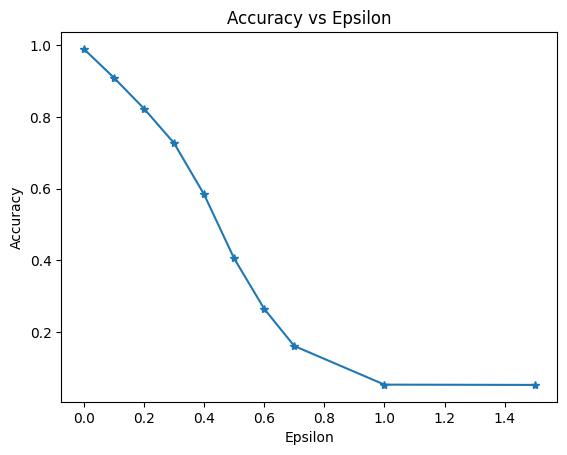

In [12]:
# 绘制模型准确率与扰动系数的关系图
fig, ax = plt.subplots(nrows=1, ncols=1)  # create figure & 1 axis
ax.plot(epsilons, accs, "*-")
ax.set_title("Accuracy vs Epsilon")
ax.set_xlabel("Epsilon")
ax.set_ylabel("Accuracy")
fig.show()

In [13]:
# 将PyTorch张量转换为NumPy数组，以便于图像显示
def to_numpy_array(tensor):
    tensor_ = tensor.cpu()
    tensor_ = tensor_.squeeze(0)
    tensor_ = tensor_.detach().numpy()
    return tensor_

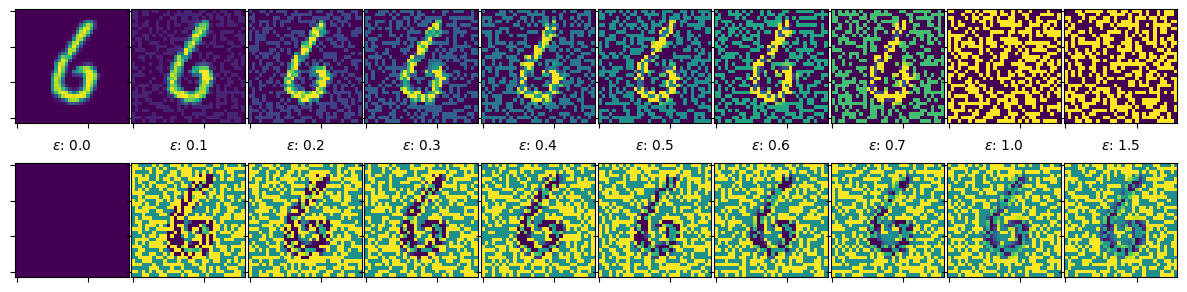

In [14]:
# 显示原始图像和受攻击后的图像，以及添加的扰动。
for i, (imgs, labels) in enumerate(test_loader):
    imgs, labels = imgs.to(device), labels.to(device)
    imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

    f = plt.figure(figsize=(15, 7))
    gs = f.add_gridspec(2, len(epsilons))
    gs.update(wspace=0.025, hspace=-0.6) 

    # plot the perturbed image
    for e in range(len(epsilons)):
        eps = epsilons[e]
        ax1 = f.add_subplot(gs[0, e])
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

        adv_imgs, _ = fgsm_attack(model, imgs, labels, eps)

        img, adv_img = imgs[50], adv_imgs[50]
        img, adv_img = to_numpy_array(img), to_numpy_array(adv_img)

        ax1.imshow(adv_img)
        ax1.set_xlabel(f"$\epsilon$: {eps}")
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    for i in range(len(epsilons)):
        eps = epsilons[i]
        ax2 = f.add_subplot(gs[1, i])
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

        adv_imgs, _ = fgsm_attack(model, imgs, labels, eps)

        img, adv_img = imgs[50], adv_imgs[50]
        img, adv_img = to_numpy_array(img), to_numpy_array(adv_img)
        noise = adv_img - img

        ax2.imshow(noise)
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])

    f.show()
    break 